# **Optimization Algorithms: Evolutionary Strategies, Genetic Algorithms, and Simulated Annealing**

This notebook provides a Python implementation of foundational metaheuristic optimization algorithms: **Evolutionary Strategies (ES)**, **Genetic Algorithms (GA)**, and **Simulated Annealing (SA)**. These algorithms are designed to tackle complex optimization problems, particularly those involving non-linear, non-differentiable, or high-dimensional objective functions where traditional gradient-based methods may struggle.

The implementations focus on minimizing a 1D real-valued function within a bounded interval, using both **binary encoding** (for ES and GA) and **real encoding** (for SA). Key components such as chromosome representation, fitness evaluation, mutation, crossover, and selection operators are defined and demonstrated.

This resource is intended for academic and educational purposes, providing a clear, commented, and self-contained reference for understanding and experimenting with these powerful optimization paradigms.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Although 3D plotting is not central to 1D optimization, included for consistency with prior notebooks.

# Set a random seed for reproducibility of results
np.random.seed(42)

# **1. Binary Encoding Utilities**

For evolutionary algorithms like Genetic Algorithms and certain Evolutionary Strategies, representing solutions as **binary strings** (chromosomes) is a common practice. This section defines utility functions for working with this binary encoding: converting binary chromosomes to real-valued numbers, initializing random populations, and evaluating the fitness of these encoded solutions.

## **1.1 Logical to Real Conversion**
The conversion from a binary vector to a real-valued number within a defined interval $[a, b]$ is crucial. A binary string of length $L$ can represent $2^L$ unique integer values. These integer values are then mapped linearly to the continuous interval. Each binary string corresponds to an unsigned integer value. For a binary vector $\mathbf{v} = [v_0, v_1, \ldots, v_{L-1}]$ where $v_i \in \{0, 1\}$ and $v_0$ is the most significant bit:
$$ \text{uint_value} = \sum_{i=0}^{L-1} v_i \cdot 2^{(L-1-i)} $$
This integer value is then scaled to the interval $[0, 1)$:
$$ \text{real_value}_{0,1} = \frac{\text{uint_value}}{2^L} $$
Finally, this value is mapped to the desired interval $[a, b)$ with a small offset to center the discrete values:
$$ \text{real_value} = a + \text{real_value}_{0,1} \cdot (b-a) + \frac{0.5 \cdot (b-a)}{2^L} $$

In [ ]:
def logical2real(logical_vector, a, b):
    """
    Converts a binary-encoded (logical) vector to a real-valued number
    within a specified interval [a, b). The mapping is designed to distribute
    values uniformly across the interval.

    Parameters:
    - logical_vector: A 1D NumPy array of booleans (binary chromosome).
    - a: Lower bound of the real-valued interval.
    - b: Upper bound of the real-valued interval.

    Returns:
    - real_value: The converted real-valued number.
    """
    len_vector = len(logical_vector)

    # Calculate the unsigned integer value represented by the binary vector.
    # The most significant bit (MSB) is at index 0 (leftmost).
    # For Python (0-indexed): sum(2**(len_vector - 1 - i)) for i where logical_vector[i] is True.
    powers_of_2 = 2**(np.arange(len_vector - 1, -1, -1)) # Generates weights [2^(L-1), 2^(L-2), ..., 2^0]
    uint_value = np.sum(logical_vector * powers_of_2) # Sum of weighted bits where the bit is True

    # Map the integer value to the interval [0, 1)
    # This represents the fractional part of the real number
    real_value_0_1 = uint_value / (2**len_vector)

    # Scale and shift to the desired interval (a, b)
    # The '+ 0.5*(b-a)/(2**len_vector)' term is to center the discrete values
    # within their respective sub-intervals, effectively mapping to (a, b) midpoint.
    real_value = a + real_value_0_1 * (b - a) + 0.5 * (b - a) / (2**len_vector)

    return real_value


In [ ]:
def BE_initpop(ngenes, popsize=1):
    """
    Initializes a population of binary-encoded individuals with random gene values.

    Parameters:
    - ngenes: The number of genes (length of the binary chromosome) for each individual.
    - popsize: The number of individuals in the population (default is 1).

    Returns:
    - initpop: A NumPy array of boolean values representing the initial population.
               Each row is an individual's chromosome (shape: popsize x ngenes).
    """
    # Generates a random boolean array where each element is True or False with 50% probability
    initpop = np.random.randint(0, 2, size=(popsize, ngenes), dtype=bool)
    return initpop


In [ ]:
def BE_evaluatefitness(f, P, a, b):
    """
    Evaluates the fitness (objective function value) for each individual in the population.
    For minimization problems, a lower fitness value indicates a better solution.

    Parameters:
    - f: Function handle (callable) of the objective function to minimize.
    - P: Population matrix, where each row is a binary-encoded individual (popsize x ngenes).
    - a: Lower bound of the real-valued search space.
    - b: Upper bound of the real-valued search space.

    Returns:
    - fit: A 1D NumPy array containing the fitness value for each individual (shape: popsize,).
    """
    fit = np.zeros(P.shape[0]) # Initialize fitness array for each individual
    for i in range(P.shape[0]):
        # Convert binary-encoded individual to real value and then evaluate its fitness
        fit[i] = f(logical2real(P[i, :], a, b))
    return fit


# **2. Genetic Algorithm (GA) Components**

Genetic Algorithms simulate natural selection and genetics to find optimal solutions. This section details the core operators that drive the GA's search process: **mutation**, **crossover**, and **selection**.

## **2.1 Uniform Mutation (Binary Encoding)**
Uniform mutation alters individual genes (bits) of a chromosome with a specified probability. For each gene in a chromosome $\mathbf{x} = [x_0, x_1, \ldots, x_{L-1}]$:
$$ x_i' = \begin{cases} 1 - x_i & \text{with probability } p_{mut} \\ x_i & \text{with probability } 1 - p_{mut} \end{cases} $$
where $p_{mut}$ is the mutation probability for each gene.

In [ ]:
def BE_MUT_unif_all(logical_x, mutprob):
    """
    Performs uniform mutation on a binary-encoded chromosome. Each gene (bit)
    in the chromosome has an independent probability 'mutprob' of flipping its value.

    Parameters:
    - logical_x: The binary-encoded chromosome (1D NumPy array of booleans).
    - mutprob: The probability of mutation for each gene (between 0 and 1).

    Returns:
    - mutated_x: The mutated chromosome as a new 1D NumPy array of booleans.
    """
    len_x = len(logical_x)
    # Generate a random probability for each gene (element) in the chromosome
    prob = np.random.rand(len_x)
    # Identify the indices of genes that should be flipped (where random prob < mutprob)
    ind_of_genes_to_mutate = np.where(prob < mutprob)[0]

    mutated_x = np.copy(logical_x) # Create a copy to ensure the original chromosome is not modified directly
    # Flip the values (True to False, False to True) of the selected genes
    mutated_x[ind_of_genes_to_mutate] = np.logical_not(logical_x[ind_of_genes_to_mutate])
    return mutated_x


## **2.2 Single-Point Crossover (Binary Encoding)**
Single-point crossover creates two offspring from two parents by selecting a random crossover point and swapping the segments of the chromosomes after that point.
Given two parents, $P_1 = [p_{1,0}, \ldots, p_{1,L-1}]$ and $P_2 = [p_{2,0}, \ldots, p_{2,L-1}]$, and a random split point $s$ ($0 < s < L-1$):
$$ O_1 = [p_{1,0}, \ldots, p_{1,s-1}, p_{2,s}, \ldots, p_{2,L-1}] $$
$$ O_2 = [p_{2,0}, \ldots, p_{2,s-1}, p_{1,s}, \ldots, p_{1,L-1}] $$
where $O_1$ and $O_2$ are the two offspring.

In [ ]:
def BE_XOVER_singlepoint(parent1, parent2):
    """
    Performs single-point crossover between two binary-encoded parents.
    A random crossover point is chosen, and the genetic material is swapped
    between the parents after this point to generate two new offspring.

    Parameters:
    - parent1: The first parent's chromosome (1D NumPy array of booleans).
    - parent2: The second parent's chromosome (1D NumPy array of booleans).

    Returns:
    - offsprings: A 2xL NumPy array of booleans, where the first row is Child 1
                  and the second row is Child 2.
    - splitpoint: The index of the crossover point. Useful for analysis/debugging.
    """
    len_chromosome = len(parent1)

    # Randomly select a split point (index). The point can be from 1 to len_chromosome - 2
    # to ensure there's at least one gene on each side of the split.
    splitpoint = np.random.randint(1, len_chromosome - 1)

    # Initialize an array to hold the two offspring chromosomes
    offsprings = np.full((2, len_chromosome), False, dtype=bool)

    # Create the first offspring
    offsprings[0, :splitpoint] = parent1[:splitpoint] # First part from parent1
    offsprings[0, splitpoint:] = parent2[splitpoint:] # Second part from parent2

    # Create the second offspring
    offsprings[1, :splitpoint] = parent2[:splitpoint] # First part from parent2
    offsprings[1, splitpoint:] = parent1[splitpoint:] # Second part from parent1

    return offsprings, splitpoint


## **2.3 Binary Tournament Selection**
Binary tournament selection is a widely used method for choosing individuals to participate in reproduction. For each slot in the mating pool, two individuals are randomly selected from the current population. The individual with the **better fitness** (lower value for minimization problems) is chosen and added to the mating pool. This process is repeated until the mating pool is filled to the desired `popsize`.

In [ ]:
def binarytournement(P, fit_P, popsize):
    """
    Performs binary tournament selection to create a mating pool.
    In each tournament, two individuals are randomly chosen from the population.
    The individual with the superior fitness (for minimization, the lower value)
    is selected to be part of the mating pool.

    Parameters:
    - P: Current population matrix (shape: current_popsize x ngenes).
    - fit_P: Fitness values for each individual in P (shape: current_popsize,).
    - popsize: The desired size of the mating pool.

    Returns:
    - MP: The mating pool, a new population of selected individuals (shape: popsize x ngenes).
    """
    ngenes = P.shape[1] # Number of genes (chromosome length)
    MP = np.full((popsize, ngenes), False, dtype=bool) # Initialize the mating pool

    current_pop_size = P.shape[0]

    for i in range(popsize):
        # Randomly select two unique indices for competitors from the current population
        competitors_indices = np.random.choice(current_pop_size, 2, replace=False)

        # Compare their fitness values and select the better one
        if fit_P[competitors_indices[0]] < fit_P[competitors_indices[1]]:
            MP[i, :] = P[competitors_indices[0], :]
        else:
            MP[i, :] = P[competitors_indices[1], :]
    return MP


# **3. Optimization Algorithms Implementations**

This section presents the implementations of three distinct optimization algorithms: Evolutionary Strategy, Genetic Algorithm, and Simulated Annealing. Each algorithm is designed to find the minimum of a given 1D objective function. A common test function, `difficult2minimafcn1D`, is introduced first.

## **3.1 Difficult Test Function**
The `difficult2minimafcn1D` is a 1D function designed to challenge optimization algorithms due to its multiple local minima, where the global minimum might be non-trivial to locate. It is defined piecewise:
$$ f(x) = \begin{cases} -e^{-(x/100)^2} & x \le 100 \\ -e^{-1} + (x-100)(x-102) & x > 100 \end{cases} $$
This function exhibits a smoother, Gaussian-like behavior for $x \le 100$ and a quadratic, parabolic-like behavior for $x > 100$. The transition at $x=100$ creates a potential challenge for search methods.

In [ ]:
def difficult2minimafcn1D(x):
    """
    A 1D test function with two minima, where the global minimum
    is rather difficult to find. Its mathematical description is provided
    in the markdown cell above.

    Parameters:
    - x: Input value(s) (can be a scalar or a NumPy array).

    Returns:
    - y: Output value(s) of the function.
    """
    # Ensure x is a NumPy array for vectorized operations, handling scalar inputs gracefully
    x_arr = np.asarray(x)
    y = np.zeros_like(x_arr, dtype=float)

    # Apply the first part of the piecewise function for x <= 100
    ind_le100 = x_arr <= 100
    y[ind_le100] = -np.exp(-(x_arr[ind_le100] / 100)**2)

    # Apply the second part of the piecewise function for x > 100
    ind_gt100 = x_arr > 100
    y[ind_gt100] = -np.exp(-1) + (x_arr[ind_gt100] - 100) * (x_arr[ind_gt100] - 102)

    # Return scalar if input was scalar, otherwise return array
    return y.item() if x_arr.ndim == 0 else y


## **3.2 (1+1) Evolution Strategy with Binary Encoding (ES-BE)**

The **(1+1) Evolution Strategy** is a simple yet powerful evolutionary algorithm. It operates with a single parent solution that generates one child solution through mutation. The child then competes with the parent, and the better of the two (for minimization, the one with lower fitness) survives to become the parent of the next generation. This strategy is 'elitist' because the best solution found so far is always preserved or improved upon.

The core loop involves:
1.  **Mutation:** A child $\mathbf{x}'$ is generated from the current parent $\mathbf{x}$ using a mutation operator, often by flipping bits with a certain probability.
2.  **Selection:** If $f(\mathbf{x}') < f(\mathbf{x})$, then $\mathbf{x}'$ replaces $\mathbf{x}$. Otherwise, $\mathbf{x}$ is retained.

### Algorithm Summary:
1.  Initialize a random parent $\mathbf{x}$.
2.  For $t = 1, \ldots, \text{niter}$:
    a.  Create a child $\mathbf{x}'$ by mutating $\mathbf{x}$.
    b.  Evaluate fitness $f(\mathbf{x})$ and $f(\mathbf{x}')$.
    c.  If $f(\mathbf{x}') < f(\mathbf{x})$, set $\mathbf{x} \leftarrow \mathbf{x}'$.
3.  Return the final $\mathbf{x}$ as the optimum.

In [ ]:
def ES_BE_1D(f, a, b, niter, ngenes, mutprob, dispAndPlot=True):
    # Initialize
    current_x_binary = BE_initpop(ngenes, 1)
    current_fitness = BE_evaluatefitness(f, current_x_binary, a, b)[0]

    best_x = logical2real(current_x_binary[0], a, b)
    best_f = current_fitness

    if dispAndPlot:
        plt.close('all')
        fig, ax = plt.subplots(figsize=(10, 6))
        domain = np.linspace(a, b, 1000)
        ax.plot(domain, f(domain), '-b', label='Function')
        best_point, = ax.plot(best_x, best_f, 'g*', markersize=10, label='Best solution')
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_title('(1+1) ES Optimization Progress')
        ax.grid(True)
        ax.legend()
        plt.show(block=False)

    print(f"Starting (1+1) ES for {niter} iterations...")
    print(f"Iteration 0: Best x = {best_x:.6f}, f(x) = {best_f:.6f}")

    for i in range(niter):
        # Generate and evaluate new candidate
        new_x_binary = BE_MUT_unif_all(current_x_binary[0], mutprob)
        new_fitness = BE_evaluatefitness(f, new_x_binary.reshape(1, -1), a, b)[0]
        new_x_real = logical2real(new_x_binary, a, b)

        # Selection
        if new_fitness < current_fitness:
            current_x_binary = new_x_binary.reshape(1, -1)
            current_fitness = new_fitness
            if new_fitness < best_f:
                best_x = new_x_real
                best_f = new_fitness
                if dispAndPlot:
                    best_point.set_data([best_x], [best_f])
                    fig.canvas.draw()
                    fig.canvas.flush_events()

        # Progress reporting every 50 iterations
        if i % 50 == 0 or i == niter - 1:
            print(f"\nIteration {i+1}/{niter}:")
            print(f"Current solution: x = {new_x_real:.6f}, f(x) = {new_fitness:.6f}")
            print(f"Best so far:     x = {best_x:.6f}, f(x) = {best_f:.6f}")
            print(f"Improvement:     {(f(best_x) - best_f)/abs(f(best_x))*100 if f(best_x) != 0 else 0:.2f}% from initial")

    if dispAndPlot:
        plt.close(fig)

    return best_x, best_f

## **3.3 Canonical Genetic Algorithm with Binary Encoding (GA-BE)**

A **Canonical Genetic Algorithm (GA)** evolves a population of solutions over generations. It uses selection, crossover, and mutation operators to produce new, potentially better, generations. This implementation includes elitism, where the best individuals from the current generation are guaranteed to be carried over to the next.

### Algorithm Summary:
1.  **Initialization:** Create an initial population $P$ of `popsize` random chromosomes.
2.  **Evaluation:** Compute the fitness of each individual in $P$.
3.  For $t = 1, \ldots, \text{generations}$:
    a.  **Selection:** Create a Mating Pool (MP) by selecting individuals from $P$ based on their fitness (e.g., using binary tournament selection).
    b.  **Crossover:** Pair individuals from MP and apply a crossover operator (e.g., single-point crossover) to create offspring population $Q$.
    c.  **Mutation:** Apply a mutation operator (e.g., uniform mutation) to each gene in $Q$ with a small probability.
    d.  **Evaluation:** Compute the fitness of each individual in $Q$.
    e.  **Replacement (Elitism):** Form the next generation $P'$ by combining $P$ and $Q$ and selecting the `popsize` best individuals.
4.  Return the best individual found in the final population.

In [ ]:
def GA_BE_1D(f, a, b, generations, chrsize, popsize, pmutallgenes, displayAndPlot=False):
    if popsize % 2 != 0:
        raise ValueError('Population size must be even for crossover.')

    # Initialize population
    P = BE_initpop(chrsize, popsize)
    fit_P = BE_evaluatefitness(f, P, a, b)

    best_idx = np.argmin(fit_P)
    best_x = logical2real(P[best_idx, :], a, b)
    best_f = fit_P[best_idx]

    if displayAndPlot:
        plt.close('all')
        fig, ax = plt.subplots(figsize=(10, 6))
        domain = np.linspace(a, b, 1000)
        ax.plot(domain, f(domain), '-b', label='Function')
        best_point, = ax.plot(best_x, best_f, 'g*', markersize=10, label='Best solution')
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_title('GA Optimization Progress')
        ax.grid(True)
        ax.legend()
        plt.show(block=False)

    print(f"Starting GA for {generations} generations with population size {popsize}...")
    print(f"Initial best: x = {best_x:.6f}, f(x) = {best_f:.6f}")

    for t in range(1, generations):
        # GA operations (selection, crossover, mutation)
        MP = binarytournement(P, fit_P, popsize)
        shuffled_indices = np.random.permutation(popsize)
        MP = MP[shuffled_indices, :]

        Q = np.full((popsize, chrsize), False, dtype=bool)
        for i in range(0, popsize, 2):
            parent1 = MP[i, :]
            parent2 = MP[i+1, :]
            offsprings, _ = BE_XOVER_singlepoint(parent1, parent2)
            Q[i, :] = offsprings[0, :]
            Q[i+1, :] = offsprings[1, :]

        for i in range(popsize):
            Q[i, :] = BE_MUT_unif_all(Q[i, :], pmutallgenes)

        fit_Q = BE_evaluatefitness(f, Q, a, b)

        # Replacement
        R = np.vstack((P, Q))
        fit_R = np.hstack((fit_P, fit_Q))
        sorted_indices = np.argsort(fit_R)
        P = R[sorted_indices[:popsize], :]
        fit_P = fit_R[sorted_indices[:popsize]]

        # Update best solution
        current_best_idx = np.argmin(fit_P)
        current_best_x = logical2real(P[current_best_idx, :], a, b)
        current_best_f = fit_P[current_best_idx]

        if current_best_f < best_f:
            best_x = current_best_x
            best_f = current_best_f
            if displayAndPlot:
                best_point.set_data([best_x], [best_f])
                fig.canvas.draw()
                fig.canvas.flush_events()

        # Progress reporting every 50 generations
        if t % 50 == 0 or t == generations - 1:
            print(f"\nGeneration {t}/{generations}:")
            print(f"Population best: x = {current_best_x:.6f}, f(x) = {current_best_f:.6f}")
            print(f"Overall best:    x = {best_x:.6f}, f(x) = {best_f:.6f}")
            print(f"Diversity:       {len(np.unique(fit_P))}/{popsize} unique fitness values")

    if displayAndPlot:
        plt.close(fig)

    return best_x, best_f, fit_P

## **3.4 Simulated Annealing with Real Encoding (SA-RE)**

**Simulated Annealing (SA)** is a probabilistic metaheuristic inspired by the annealing process in metallurgy, where a material is heated and then slowly cooled to increase its crystal size and perfect its structure, thereby reducing defects. In optimization, this translates to exploring the search space at high "temperatures" (early iterations, allowing greater exploration and acceptance of worse solutions) and gradually reducing the temperature (later iterations, favoring exploitation and better solutions). This strategy helps in escaping local minima.

### Key Concepts:
* **Temperature Schedule ($T_t$):** A function that controls the 'cooling' process, typically decreasing over iterations. A common schedule is exponential decay: $T_t = T_0 \cdot e^{-\lambda t}$, where $T_0$ is the initial temperature, $\lambda$ is the decay rate, and $t$ is the iteration number.
* **Perturbation:** A mechanism to generate a new candidate solution from the current one, often by adding a small random step.
* **Acceptance Probability:** The likelihood of accepting a new solution, especially if it's worse than the current one. This is typically governed by the **Metropolis Criterion**:
    $$ P(\text{accept}) = \begin{cases} 1 & \text{if } f(\mathbf{x}') < f(\mathbf{x}) \\ e^{-\frac{f(\mathbf{x}') - f(\mathbf{x})}{T_t}} & \text{if } f(\mathbf{x}') \ge f(\mathbf{x}) \end{cases} $$
    where $f(\mathbf{x})$ is the current fitness, $f(\mathbf{x}')$ is the candidate fitness, and $T_t$ is the current temperature.

### Algorithm Summary:
1.  Initialize a random current solution $\mathbf{x}$ and the best solution found $\mathbf{x}_{best}$.
2.  Define a temperature schedule $T_t$ for $t = 1, \ldots, \text{niter}$.
3.  For $t = 1, \ldots, \text{niter}$:
    a.  Generate a new candidate solution $\mathbf{x}'$ by perturbing $\mathbf{x}$.
    b.  Evaluate fitness $f(\mathbf{x}')$.
    c.  Decide whether to accept $\mathbf{x}'$ as the new current solution based on the Metropolis Criterion.
    d.  If $f(\mathbf{x}') < f(\mathbf{x}_{best})$, update $\mathbf{x}_{best} \leftarrow \mathbf{x}'$.
4.  Return $\mathbf{x}_{best}$ as the estimated optimum.

In [ ]:
def perturb(current_x, a, b):
    """
    Generates a new candidate solution by perturbing the current solution.
    The perturbation is a random step, scaled by a fraction of the search interval width,
    and clipped to ensure the new solution stays within the defined bounds [a, b].

    Parameters:
    - current_x: The current real-valued solution.
    - a: Lower bound of the search space.
    - b: Upper bound of the search space.

    Returns:
    - new_x: The perturbed candidate solution.
    """
    # Add a random step to the current solution. The step size is proportional to the interval width (b-a).
    # The `(np.random.rand() - 0.5)` term ensures the step is centered around zero.
    new_x = current_x + 0.2 * (b - a) * (np.random.rand() - 0.5)

    # Clip (constrain) the new solution to ensure it remains within the specified bounds [a, b]
    new_x = np.clip(new_x, a, b)

    return new_x

def SA_RE_1D(f, a, b, niter, decay_rate, dispAndPlot=False):
    # Initialize temperature schedule
    temperature_schedule = np.exp(-decay_rate * np.arange(1, niter + 1))

    # Initialize current and best solutions
    current_x = np.random.uniform(a, b)
    current_y = f(current_x)
    best_x = current_x
    best_y = current_y

    if dispAndPlot:
        plt.close('all')
        fig, ax = plt.subplots(figsize=(10, 6))
        domain = np.linspace(a, b, 1000)
        ax.plot(domain, f(domain), '-b', label='Function')
        current_point, = ax.plot(current_x, current_y, 'ro', label='Current')
        best_point, = ax.plot(best_x, best_y, 'g*', markersize=10, label='Best')
        ax.set_xlabel('x')
        ax.set_ylabel('f(x)')
        ax.set_title('SA Optimization Progress')
        ax.grid(True)
        ax.legend()
        plt.show(block=False)

    print(f"Starting SA for {niter} iterations with decay rate {decay_rate:.4f}...")
    print(f"Initial solution: x = {current_x:.6f}, f(x) = {current_y:.6f}")

    for i in range(niter):
        # Generate new candidate
        new_x = perturb(current_x, a, b)
        new_y = f(new_x)

        # Metropolis criterion
        if new_y < current_y:
            current_x = new_x
            current_y = new_y
        else:
            delta_E = new_y - current_y
            acceptance_prob = np.exp(-delta_E / temperature_schedule[i])
            if np.random.rand() < acceptance_prob:
                current_x = new_x
                current_y = new_y

        # Update best solution
        if new_y < best_y:
            best_x = new_x
            best_y = new_y
            if dispAndPlot:
                best_point.set_data([best_x], [best_y])
                current_point.set_data([current_x], [current_y])
                fig.canvas.draw()
                fig.canvas.flush_events()

        # Progress reporting every 50 iterations
        if i % 50 == 0 or i == niter - 1:
            print(f"\nIteration {i+1}/{niter}:")
            print(f"Current solution: x = {current_x:.6f}, f(x) = {current_y:.6f}")
            print(f"Best so far:     x = {best_x:.6f}, f(x) = {best_y:.6f}")
            print(f"Temperature:     {temperature_schedule[i]:.6f}")
            print(f"Acceptance rate: {min(1, np.exp(-(new_y-current_y)/temperature_schedule[i])):.2%}")

    if dispAndPlot:
        plt.close(fig)

    return best_x, best_y

# **4. Main Execution and Examples**

This section demonstrates how to use the implemented optimization algorithms to find the minimum of various 1D test functions. Examples for the Rastrigin function, a sinusoidal function, and the `difficult2minimafcn1D` are provided for each algorithm.

## **4.1 Example: (1+1) Evolution Strategy (ES-BE)**
Demonstrating ES-BE on common 1D test functions.


--- (1+1) Evolution Strategy (ES-BE) Examples ---

Running ES-BE on Rastrigin function...
Known optimum for Rastrigin: x = 0.0 (y = 0.0)


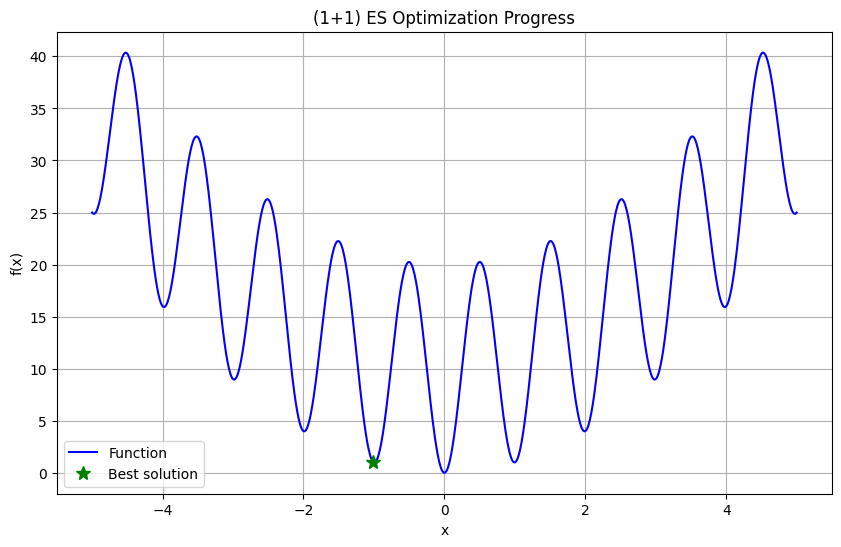

Starting (1+1) ES for 1000 iterations...
Iteration 0: Best x = -1.006541, f(x) = 1.021570

Iteration 1/1000:
Current solution: x = -1.005874, f(x) = 1.018591
Best so far:     x = -1.005874, f(x) = 1.018591
Improvement:     0.00% from initial

Iteration 51/1000:
Current solution: x = -0.996709, f(x) = 0.995567
Best so far:     x = -0.996099, f(x) = 0.995217
Improvement:     0.00% from initial

Iteration 101/1000:
Current solution: x = -1.000981, f(x) = 1.002154
Best so far:     x = -0.996099, f(x) = 0.995217
Improvement:     0.00% from initial

Iteration 151/1000:
Current solution: x = -1.000981, f(x) = 1.002154
Best so far:     x = -0.996099, f(x) = 0.995217
Improvement:     0.00% from initial

Iteration 201/1000:
Current solution: x = -0.996099, f(x) = 0.995217
Best so far:     x = -0.996099, f(x) = 0.995217
Improvement:     0.00% from initial

Iteration 251/1000:
Current solution: x = -0.996099, f(x) = 0.995217
Best so far:     x = -0.996099, f(x) = 0.995217
Improvement:     0.00% fr

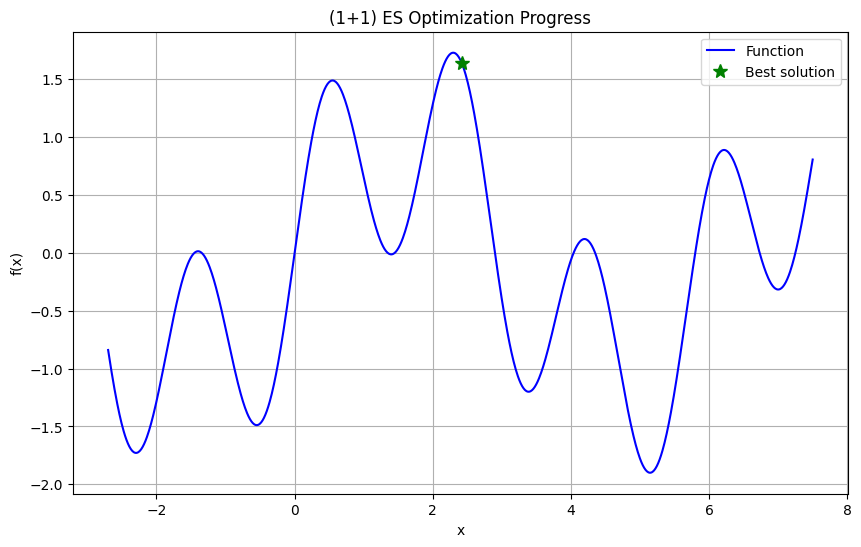

Starting (1+1) ES for 1500 iterations...
Iteration 0: Best x = 2.420121, f(x) = 1.637872

Iteration 1/1500:
Current solution: x = 2.425102, f(x) = 1.630479
Best so far:     x = 2.425102, f(x) = 1.630479
Improvement:     0.00% from initial

Iteration 51/1500:
Current solution: x = 3.744887, f(x) = -0.650675
Best so far:     x = 3.705043, f(x) = -0.748652
Improvement:     0.00% from initial

Iteration 101/1500:
Current solution: x = -1.423439, f(x) = 0.010312
Best so far:     x = 3.675316, f(x) = -0.818860
Improvement:     0.00% from initial

Iteration 151/1500:
Current solution: x = 3.675005, f(x) = -0.819578
Best so far:     x = 3.675005, f(x) = -0.819578
Improvement:     0.00% from initial

Iteration 201/1500:
Current solution: x = 3.677495, f(x) = -0.813822
Best so far:     x = 3.675005, f(x) = -0.819578
Improvement:     0.00% from initial

Iteration 251/1500:
Current solution: x = 3.694927, f(x) = -0.772880
Best so far:     x = 3.675005, f(x) = -0.819578
Improvement:     0.00% from 

In [ ]:
print("\n--- (1+1) Evolution Strategy (ES-BE) Examples ---")

# Example 1 - Rastrigin Function
print("\nRunning ES-BE on Rastrigin function...")
f_rastrigin = lambda x: 10 + x**2 - 10 * np.cos(2 * np.pi * x)
a_rastrigin = -5
b_rastrigin = 5
niter_es = 1000
ngenes_es = 20 # Increased genes for better resolution
mutprob_es = 0.05 # Reduced mutation probability for stability
disp_es = True

print(f'Known optimum for Rastrigin: x = 0.0 (y = 0.0)')
[best_x_es_rastrigin, best_y_es_rastrigin] = ES_BE_1D(f_rastrigin, a_rastrigin, b_rastrigin, niter_es, ngenes_es, mutprob_es, disp_es)
print(f'ES-BE found for Rastrigin: x_opt = {best_x_es_rastrigin:.4f}, f_opt = {best_y_es_rastrigin:.4f}')


# Example 2 - Sinusoidal shaped function
print("\nRunning ES-BE on Sinusoidal function...")
f_sinusoidal = lambda x: np.sin(x) + np.sin((10.0 / 3.0) * x)
a_sinusoidal = -2.7
b_sinusoidal = 7.5
niter_es_sin = 1500 # More iterations
ngenes_es_sin = 20
mutprob_es_sin = 0.05
disp_es_sin = True

print(f'Known optimum for Sinusoidal: x = 5.145735 (y = -1.8996)')
[best_x_es_sinusoidal, best_y_es_sinusoidal] = ES_BE_1D(f_sinusoidal, a_sinusoidal, b_sinusoidal, niter_es_sin, ngenes_es_sin, mutprob_es_sin, disp_es_sin)
print(f'ES-BE found for Sinusoidal: x_opt = {best_x_es_sinusoidal:.4f}, f_opt = {best_y_es_sinusoidal:.4f}')


## **4.2 Example: Canonical Genetic Algorithm (GA-BE)**
Demonstrating GA-BE on common 1D test functions.


--- Canonical Genetic Algorithm (GA-BE) Examples ---

Running GA-BE on Rastrigin function...
Known optimum for Rastrigin: x = 0.0 (y = 0.0)


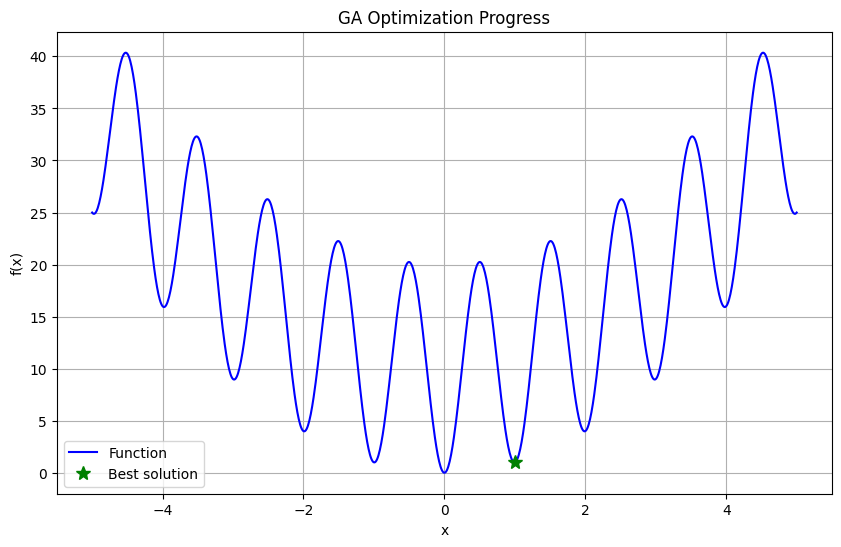

Starting GA for 200 generations with population size 50...
Initial best: x = 1.005054, f(x) = 1.015173

Generation 50/200:
Population best: x = -0.000005, f(x) = 0.000000
Overall best:    x = -0.000005, f(x) = 0.000000
Diversity:       1/50 unique fitness values

Generation 100/200:
Population best: x = -0.000005, f(x) = 0.000000
Overall best:    x = -0.000005, f(x) = 0.000000
Diversity:       1/50 unique fitness values

Generation 150/200:
Population best: x = -0.000005, f(x) = 0.000000
Overall best:    x = -0.000005, f(x) = 0.000000
Diversity:       1/50 unique fitness values

Generation 199/200:
Population best: x = -0.000005, f(x) = 0.000000
Overall best:    x = -0.000005, f(x) = 0.000000
Diversity:       1/50 unique fitness values
GA-BE found for Rastrigin: x_opt = -0.0000, f_opt = 0.0000

Running GA-BE on Sinusoidal function...
Known optimum for Sinusoidal: x = 5.145735 (y = -1.8996)


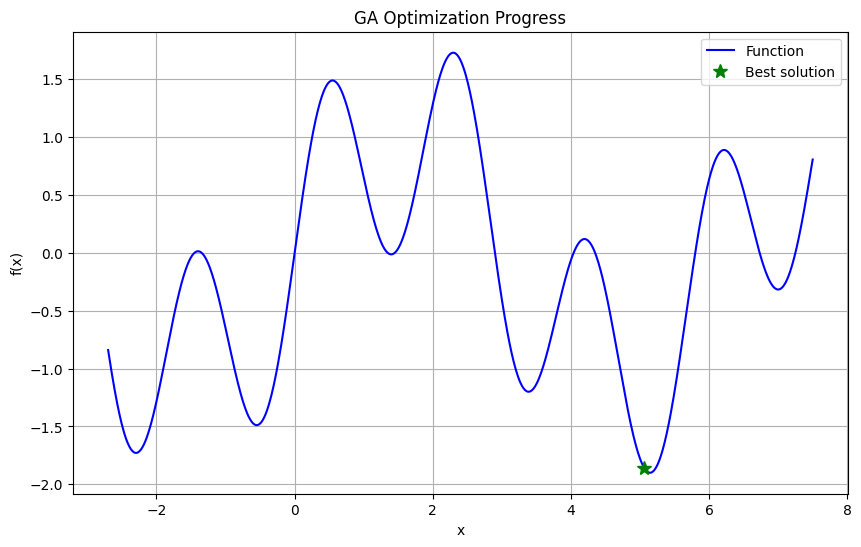

Starting GA for 300 generations with population size 50...
Initial best: x = 5.059536, f(x) = -1.856011

Generation 50/300:
Population best: x = 5.145731, f(x) = -1.899599
Overall best:    x = 5.145731, f(x) = -1.899599
Diversity:       1/50 unique fitness values

Generation 100/300:
Population best: x = 5.145731, f(x) = -1.899599
Overall best:    x = 5.145731, f(x) = -1.899599
Diversity:       1/50 unique fitness values

Generation 150/300:
Population best: x = 5.145731, f(x) = -1.899599
Overall best:    x = 5.145731, f(x) = -1.899599
Diversity:       1/50 unique fitness values

Generation 200/300:
Population best: x = 5.145731, f(x) = -1.899599
Overall best:    x = 5.145731, f(x) = -1.899599
Diversity:       1/50 unique fitness values

Generation 250/300:
Population best: x = 5.145731, f(x) = -1.899599
Overall best:    x = 5.145731, f(x) = -1.899599
Diversity:       1/50 unique fitness values

Generation 299/300:
Population best: x = 5.145731, f(x) = -1.899599
Overall best:    x = 5.

In [ ]:
print("\n--- Canonical Genetic Algorithm (GA-BE) Examples ---")

# Example 1 - Rastrigin Function
print("\nRunning GA-BE on Rastrigin function...")
f_rastrigin = lambda x: 10 + x**2 - 10 * np.cos(2 * np.pi * x)
a_rastrigin = -5
b_rastrigin = 5
generations_ga = 200
chrsize_ga = 20 # Chromosome size
popsize_ga = 50 # Population size (must be even)
pmutallgenes_ga = 0.05 # Per-gene mutation probability
disp_ga = True

print(f'Known optimum for Rastrigin: x = 0.0 (y = 0.0)')
[best_x_ga_rastrigin, best_y_ga_rastrigin, _] = GA_BE_1D(f_rastrigin, a_rastrigin, b_rastrigin, generations_ga, chrsize_ga, popsize_ga, pmutallgenes_ga, disp_ga)
print(f'GA-BE found for Rastrigin: x_opt = {best_x_ga_rastrigin:.4f}, f_opt = {best_y_ga_rastrigin:.4f}')

# Example 2 - Sinusoidal shaped function
print("\nRunning GA-BE on Sinusoidal function...")
f_sinusoidal = lambda x: np.sin(x) + np.sin((10.0 / 3.0) * x)
a_sinusoidal = -2.7
b_sinusoidal = 7.5
generations_ga_sin = 300
chrsize_ga_sin = 20
popsize_ga_sin = 50
pmutallgenes_ga_sin = 0.05
disp_ga_sin = True

print(f'Known optimum for Sinusoidal: x = 5.145735 (y = -1.8996)')
[best_x_ga_sinusoidal, best_y_ga_sinusoidal, _] = GA_BE_1D(f_sinusoidal, a_sinusoidal, b_sinusoidal, generations_ga_sin, chrsize_ga_sin, popsize_ga_sin, pmutallgenes_ga_sin, disp_ga_sin)
print(f'GA-BE found for Sinusoidal: x_opt = {best_x_ga_sinusoidal:.4f}, f_opt = {best_y_ga_sinusoidal:.4f}')


## **4.3 Example: Simulated Annealing (SA-RE)**
Demonstrating SA-RE on common 1D test functions.


--- Simulated Annealing (SA-RE) Examples ---

Running SA-RE on Rastrigin function...
Known optimum for Rastrigin: x = 0.0 (y = 0.0)


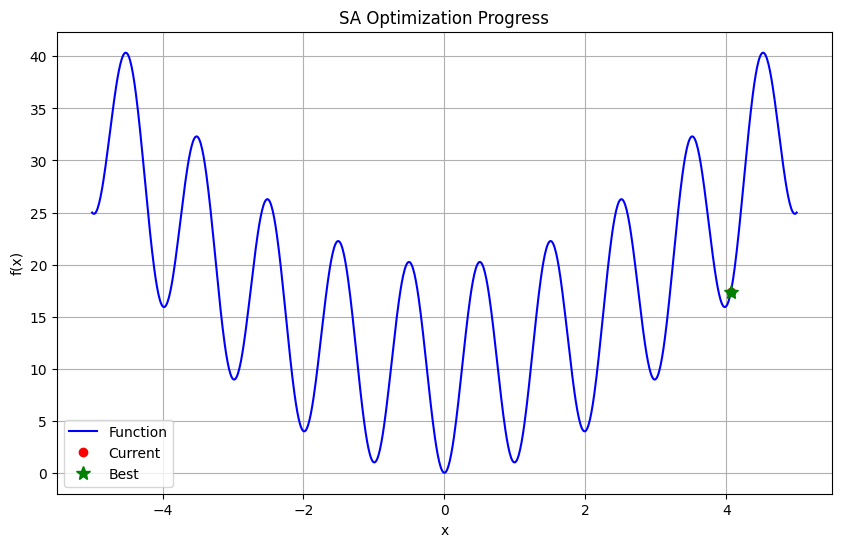

Starting SA for 1000 iterations with decay rate 0.0100...
Initial solution: x = 4.065981, f(x) = 17.379311

Iteration 1/1000:
Current solution: x = 4.065981, f(x) = 17.379311
Best so far:     x = 4.065981, f(x) = 17.379311
Temperature:     0.990050
Acceptance rate: 0.01%

Iteration 51/1000:
Current solution: x = 0.980707, f(x) = 1.035169
Best so far:     x = 0.980707, f(x) = 1.035169
Temperature:     0.600496
Acceptance rate: 0.00%

Iteration 101/1000:
Current solution: x = 0.056786, f(x) = 0.633026
Best so far:     x = 0.056786, f(x) = 0.633026
Temperature:     0.364219
Acceptance rate: 0.00%

Iteration 151/1000:
Current solution: x = 0.006443, f(x) = 0.008234
Best so far:     x = 0.001533, f(x) = 0.000466
Temperature:     0.220910
Acceptance rate: 0.00%

Iteration 201/1000:
Current solution: x = 0.024393, f(x) = 0.117820
Best so far:     x = 0.001533, f(x) = 0.000466
Temperature:     0.133989
Acceptance rate: 0.00%

Iteration 251/1000:
Current solution: x = -0.015452, f(x) = 0.047329

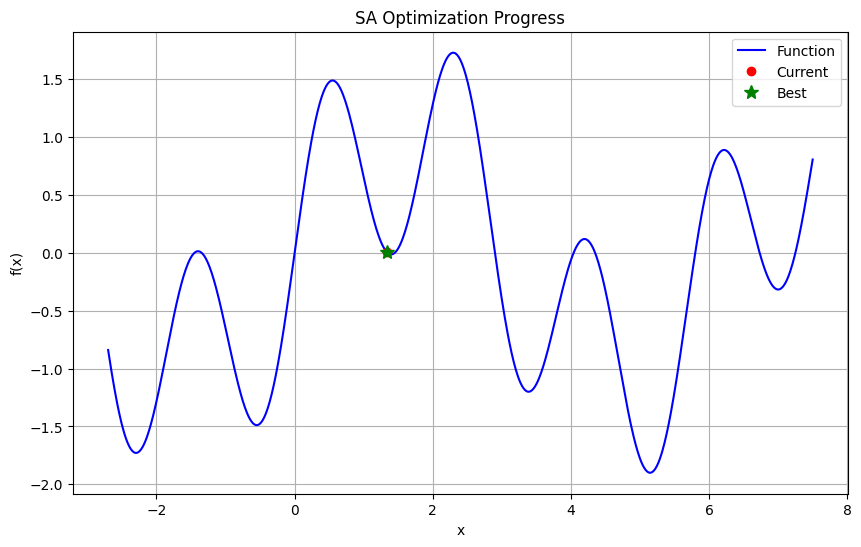

Starting SA for 1500 iterations with decay rate 0.0100...
Initial solution: x = 1.336188, f(x) = 0.005813

Iteration 1/1500:
Current solution: x = 2.069287, f(x) = 1.454805
Best so far:     x = 1.336188, f(x) = 0.005813
Temperature:     0.990050
Acceptance rate: 100.00%

Iteration 51/1500:
Current solution: x = -1.173832, f(x) = -0.225257
Best so far:     x = -0.547908, f(x) = -1.488424
Temperature:     0.600496
Acceptance rate: 67.70%

Iteration 101/1500:
Current solution: x = -2.174502, f(x) = -1.645374
Best so far:     x = -2.306808, f(x) = -1.727632
Temperature:     0.364219
Acceptance rate: 100.00%

Iteration 151/1500:
Current solution: x = -2.125796, f(x) = -1.569206
Best so far:     x = -2.306808, f(x) = -1.727632
Temperature:     0.220910
Acceptance rate: 100.00%

Iteration 201/1500:
Current solution: x = -2.438938, f(x) = -1.608451
Best so far:     x = -2.287110, f(x) = -1.727833
Temperature:     0.133989
Acceptance rate: 0.32%

Iteration 251/1500:
Current solution: x = -2.312

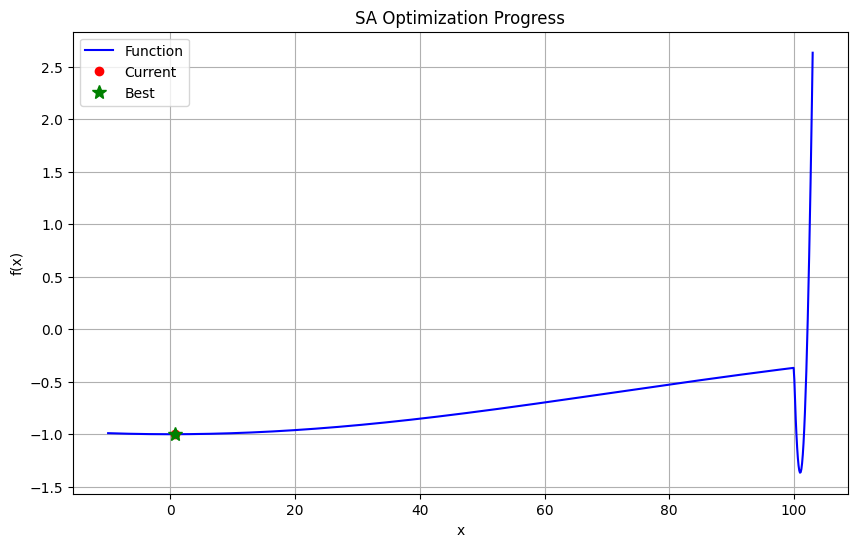

Starting SA for 2000 iterations with decay rate 0.0050...
Initial solution: x = 0.736062, f(x) = -0.999946

Iteration 1/2000:
Current solution: x = -5.528728, f(x) = -0.996948
Best so far:     x = 0.736062, f(x) = -0.999946
Temperature:     0.995012
Acceptance rate: 100.00%

Iteration 51/2000:
Current solution: x = 101.960161, f(x) = -0.445971
Best so far:     x = 100.539504, f(x) = -1.155823
Temperature:     0.774916
Acceptance rate: 100.00%

Iteration 101/2000:
Current solution: x = 34.780230, f(x) = -0.886064
Best so far:     x = 100.539504, f(x) = -1.155823
Temperature:     0.603506
Acceptance rate: 100.00%

Iteration 151/2000:
Current solution: x = 21.315111, f(x) = -0.955583
Best so far:     x = 100.539504, f(x) = -1.155823
Temperature:     0.470011
Acceptance rate: 100.00%

Iteration 201/2000:
Current solution: x = 2.761557, f(x) = -0.999238
Best so far:     x = 100.539504, f(x) = -1.155823
Temperature:     0.366045
Acceptance rate: 100.00%

Iteration 251/2000:
Current solution:

In [ ]:
print("\n--- Simulated Annealing (SA-RE) Examples ---")

# Example 1 - Rastrigin Function
print("\nRunning SA-RE on Rastrigin function...")
f_rastrigin = lambda x: 10 + x**2 - 10 * np.cos(2 * np.pi * x)
a_rastrigin = -5
b_rastrigin = 5
niter_sa = 1000
decay_rate_sa = 0.01 # Temperature decay rate
disp_sa = True

print(f'Known optimum for Rastrigin: x = 0.0 (y = 0.0)')
[best_x_sa_rastrigin, best_y_sa_rastrigin] = SA_RE_1D(f_rastrigin, a_rastrigin, b_rastrigin, niter_sa, decay_rate_sa, disp_sa)
print(f'SA-RE found for Rastrigin: x_opt = {best_x_sa_rastrigin:.4f}, f_opt = {best_y_sa_rastrigin:.4f}')

# Example 2 - Sinusoidal shaped function
print("\nRunning SA-RE on Sinusoidal function...")
f_sinusoidal = lambda x: np.sin(x) + np.sin((10.0 / 3.0) * x)
a_sinusoidal = -2.7
b_sinusoidal = 7.5
niter_sa_sin = 1500
decay_rate_sa_sin = 0.01
disp_sa_sin = True

print(f'Known optimum for Sinusoidal: x = 5.145735 (y = -1.8996)')
[best_x_sa_sinusoidal, best_y_sa_sinusoidal] = SA_RE_1D(f_sinusoidal, a_sinusoidal, b_sinusoidal, niter_sa_sin, decay_rate_sa_sin, disp_sa_sin)
print(f'SA-RE found for Sinusoidal: x_opt = {best_x_sa_sinusoidal:.4f}, f_opt = {best_y_sa_sinusoidal:.4f}')

# Example 3 - Difficult to Minima Function 1D
print("\nRunning SA-RE on Difficult to Minima Function 1D...")
a_difficult = -10
b_difficult = 103
niter_sa_difficult = 2000 # More iterations for this challenging function
decay_rate_sa_difficult = 0.005 # Slower cooling for better exploration
disp_sa_difficult = True

print(f'Known global optimum for Difficult Function: approximately x = 101 (y = -1.9996)')
[best_x_sa_difficult, best_y_sa_difficult] = SA_RE_1D(difficult2minimafcn1D, a_difficult, b_difficult, niter_sa_difficult, decay_rate_sa_difficult, disp_sa_difficult)
print(f'SA-RE found for Difficult Function: x_opt = {best_x_sa_difficult:.4f}, f_opt = {best_y_sa_difficult:.4f}')
